# 04: Sensitivity & Landscape (脆弱性景观)

目标：由内而外描绘系统脆弱性的相图——从心理阈值 ($\phi,	heta$) 到信息密度 ($k$)、媒体生态 ($n_w/n_m$)、社会耦合 ($\eta$)。

- Part 1: Chi/rc Landscape over ($\phi,	heta$) with rc 等高线。
- Part 2: 信息密度 $k$ 对敏感度/临界点的影响（理论曲线）。
- Part 3: 媒体生态 $n_w/n_m$ 改变 rc（理论扫描）。
- Part 4: 社会耦合 $\eta$ 的 ABM 对照（示例 r-Q, r-A）。


In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker

sns.set_theme(style="whitegrid", palette="deep")

ROOT = Path.cwd()
if not (ROOT / 'src').exists() and (ROOT.parent / 'src').exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
        sys.path.insert(0, str(ROOT))

from src import theory
from src.network_sim import NetworkAgentModel, NetworkConfig

# 统一参数
n_m, n_w = 10, 5
phi0, theta0 = 0.54, 0.46
k_default = 50
output_dir = ROOT / 'outputs'
fig_dir = output_dir / 'figs'
data_dir = output_dir / 'data'
for d in (fig_dir, data_dir):
    d.mkdir(parents=True, exist_ok=True)


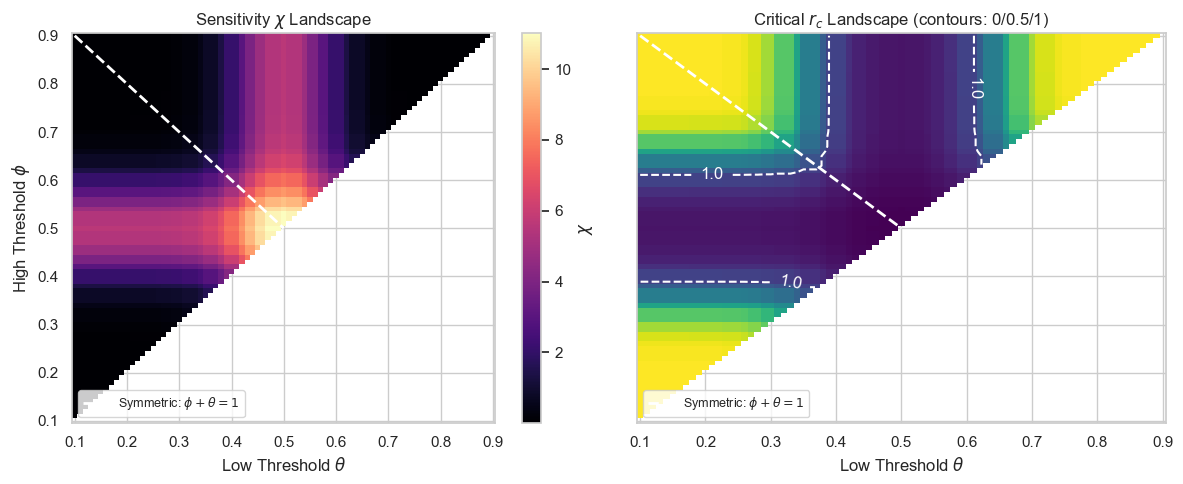


沿对称对角线 φ = 1 - θ 的理论验证：


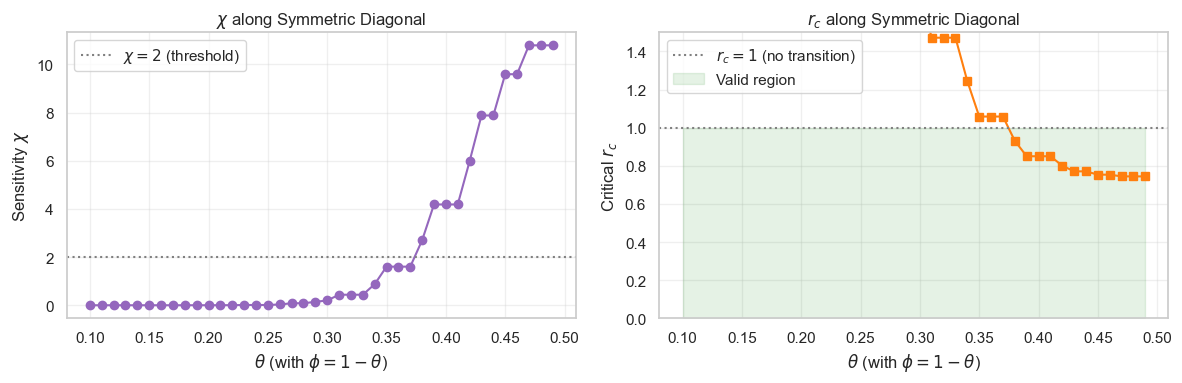

  θ=0.46 (φ=0.54): χ=9.596, rc=0.753
  当 χ > 2 时，相变存在（rc < 1）


In [2]:
# Part 1: Chi/rc landscape over (phi, theta)
# **重要说明**：理论公式 rc 是在对称假设 φ + θ = 1 下推导的。
# 图中白色虚线标注了满足此假设的区域（φ = 1 - θ 对角线）。
# 对角线以外的区域仅供参考，严格理论验证应沿对角线进行。

phi_range = np.linspace(0.1, 0.9, 81)
theta_range = np.linspace(0.1, 0.9, 81)
chi_map = np.full((len(phi_range), len(theta_range)), np.nan)
rc_map = np.full_like(chi_map, np.nan, dtype=float)
for i, phi in enumerate(phi_range):
    for j, theta in enumerate(theta_range):
        if theta >= phi:  # 约束：theta < phi（低阈值 < 高阈值）
            continue
        chi = theory.calculate_chi(phi, theta, k_default)
        rc = theory.calculate_rc(n_m, n_w, chi)
        chi_map[i, j] = chi
        rc_map[i, j] = rc

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

c0 = ax[0].pcolormesh(theta_range, phi_range, chi_map, shading='auto', cmap='magma')
ax[0].set_xlabel(r'Low Threshold $\theta$')
ax[0].set_ylabel(r'High Threshold $\phi$')
ax[0].set_title(r'Sensitivity $\chi$ Landscape')
fig.colorbar(c0, ax=ax[0], label=r'$\chi$')
# 添加对称假设线 φ + θ = 1 => φ = 1 - θ
sym_theta = np.linspace(0.1, 0.5, 50)
sym_phi = 1.0 - sym_theta
ax[0].plot(sym_theta, sym_phi, 'w--', linewidth=2, label=r'Symmetric: $\phi + \theta = 1$')
ax[0].legend(loc='lower left', fontsize=9)

c1 = ax[1].pcolormesh(theta_range, phi_range, rc_map, shading='auto', cmap='viridis')
cs = ax[1].contour(theta_range, phi_range, rc_map, levels=[0.0, 0.5, 1.0], colors=['red','orange','white'], linestyles='--')
ax[1].clabel(cs, fmt='%1.1f')
ax[1].set_xlabel(r'Low Threshold $\theta$')
ax[1].set_title(r'Critical $r_c$ Landscape (contours: 0/0.5/1)')
ax[1].plot(sym_theta, sym_phi, 'w--', linewidth=2, label=r'Symmetric: $\phi + \theta = 1$')
ax[1].legend(loc='lower left', fontsize=9)

fig.tight_layout()
fig.savefig(fig_dir / 'fig4a_chi_rc_landscape.png', dpi=200)
plt.show()

# Part 1b: 严格沿对称对角线扫描（理论验证）
print("\n沿对称对角线 φ = 1 - θ 的理论验证：")
theta_diag = np.linspace(0.1, 0.49, 40)
phi_diag = 1.0 - theta_diag
chi_diag = [theory.calculate_chi(phi, theta, k_default) for phi, theta in zip(phi_diag, theta_diag)]
rc_diag = [float(theory.calculate_rc(n_m, n_w, chi)) for chi in chi_diag]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax1, ax2 = axes

# χ vs θ (沿对角线)
ax1.plot(theta_diag, chi_diag, 'o-', color='tab:purple')
ax1.axhline(2.0, color='gray', linestyle=':', label=r'$\chi = 2$ (threshold)')
ax1.set_xlabel(r'$\theta$ (with $\phi = 1 - \theta$)')
ax1.set_ylabel(r'Sensitivity $\chi$')
ax1.set_title(r'$\chi$ along Symmetric Diagonal')
ax1.legend()
ax1.grid(True, alpha=0.3)

# rc vs θ (沿对角线)
ax2.plot(theta_diag, rc_diag, 's-', color='tab:orange')
ax2.axhline(1.0, color='gray', linestyle=':', label=r'$r_c = 1$ (no transition)')
ax2.fill_between(theta_diag, 0, 1, alpha=0.1, color='green', label='Valid region')
ax2.set_xlabel(r'$\theta$ (with $\phi = 1 - \theta$)')
ax2.set_ylabel(r'Critical $r_c$')
ax2.set_title(r'$r_c$ along Symmetric Diagonal')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1.5)

fig.tight_layout()
fig.savefig(fig_dir / 'fig4a2_symmetric_diagonal.png', dpi=200)
plt.show()

# 打印关键点
print(f"  θ=0.46 (φ=0.54): χ={chi_diag[np.argmin(np.abs(theta_diag-0.46))]:.3f}, rc={rc_diag[np.argmin(np.abs(theta_diag-0.46))]:.3f}")
print(f"  当 χ > 2 时，相变存在（rc < 1）")


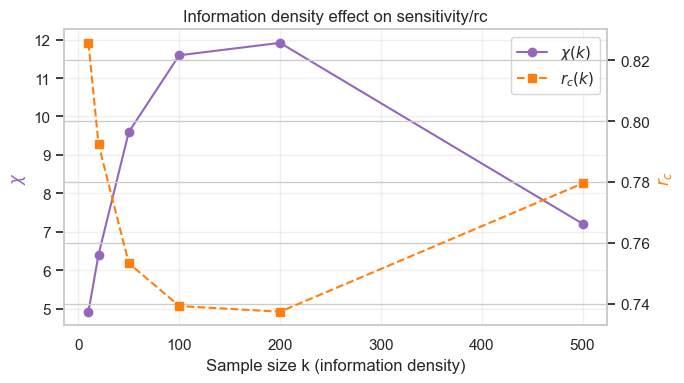

In [3]:
# Part 2: 信息密度 k 对 chi/rc 的影响（理论）
k_list = np.array([10, 20, 50, 100, 200, 500])
chi_k = [theory.calculate_chi(phi0, theta0, k) for k in k_list]
rc_k = [theory.calculate_rc(n_m, n_w, chi) for chi in chi_k]

fig, ax1 = plt.subplots(figsize=(7,4))
ax2 = ax1.twinx()
ax1.plot(k_list, chi_k, 'o-', color='tab:purple', label=r'$\chi(k)$')
ax2.plot(k_list, rc_k, 's--', color='tab:orange', label=r'$r_c(k)$')
ax1.set_xlabel('Sample size k (information density)')
ax1.set_ylabel(r'$\chi$', color='tab:purple')
ax2.set_ylabel(r'$r_c$', color='tab:orange')
ax1.set_title('Information density effect on sensitivity/rc')
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best')
ax1.grid(True, alpha=0.3)
fig.tight_layout()
fig.savefig(fig_dir / 'fig4b_k_effect_chi_rc.png', dpi=200)
plt.show()


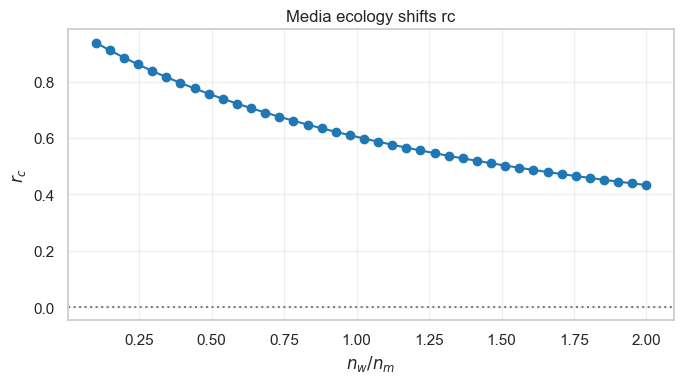

In [4]:
# Part 3: 媒体生态 Ratio = n_w / n_m 对 rc 的影响（理论）
ratio_vals = np.linspace(0.1, 2.0, 40)
chi_ref = theory.calculate_chi(phi0, theta0, k_default)
rc_ratio = [theory.calculate_rc(n_m=1.0, n_w=ratio, chi=chi_ref) for ratio in ratio_vals]
rc_ratio = np.array(rc_ratio)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(ratio_vals, rc_ratio, 'o-', color='tab:blue')
ax.axhline(0, color='gray', linestyle=':')
ax.set_xlabel(r'$n_w / n_m$')
ax.set_ylabel(r'$r_c$')
ax.set_title('Media ecology shifts rc')
ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.savefig(fig_dir / 'fig4c_media_ratio_rc.png', dpi=200)
plt.show()


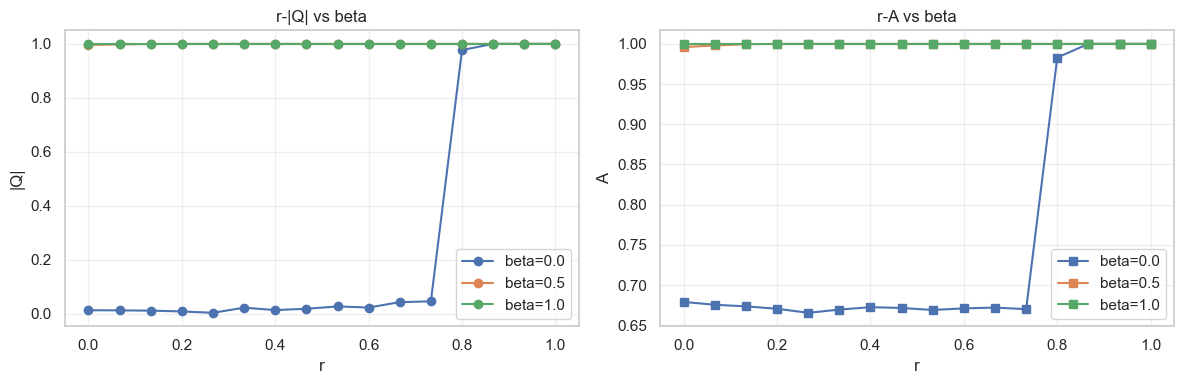

In [5]:
# Part 4: 社会耦合 beta 对 ABM 的影响（示例）
r_scan = np.linspace(0, 1.0, 16)
beta_list = [0.0, 0.5, 1.0]
results = {}
for beta in beta_list:
    q_means = []
    a_means = []
    for r in r_scan:
        cfg = NetworkConfig(
            n=400,
            avg_degree=50,
            model="er",
            beta=beta,
            r=r,
            n_m=n_m,
            n_w=n_w,
            phi=phi0,
            theta=theta0,
            seed=0,
            init_state="medium",
            sample_mode="fixed",
            sample_n=k_default,
            symmetric_mode=True,
        )
        model = NetworkAgentModel(cfg)
        t, q_traj, a_traj = model.run(steps=400, record_interval=10)
        q_means.append(np.mean(np.abs(q_traj[-5:])))
        a_means.append(np.mean(a_traj[-5:]))
    results[beta] = {"q": np.array(q_means), "a": np.array(a_means)}

fig, ax = plt.subplots(1,2, figsize=(12,4))
for beta in beta_list:
    ax[0].plot(r_scan, results[beta]['q'], marker='o', label=f'beta={beta}')
    ax[1].plot(r_scan, results[beta]['a'], marker='s', label=f'beta={beta}')
ax[0].set_xlabel('r'); ax[0].set_ylabel('|Q|'); ax[0].set_title('r-|Q| vs beta')
ax[1].set_xlabel('r'); ax[1].set_ylabel('A'); ax[1].set_title('r-A vs beta')
for a in ax: a.legend(); a.grid(True, alpha=0.3)
fig.tight_layout()
fig.savefig(fig_dir / 'fig4d_beta_abm_q_a.png', dpi=200)
plt.show()

# 保存数据
np.savez(
    data_dir / 'note4_sensitivity_data.npz',
    phi_range=phi_range,
    theta_range=theta_range,
    chi_map=chi_map,
    rc_map=rc_map,
    k_list=k_list,
    chi_k=chi_k,
    rc_k=rc_k,
    ratio_vals=ratio_vals,
    rc_ratio=rc_ratio,
    r_scan=r_scan,
    beta_list=np.array(beta_list),
    q_beta=np.stack([results[b]['q'] for b in beta_list]),
    a_beta=np.stack([results[b]['a'] for b in beta_list]),
)


In [6]:
print('Figures saved to', fig_dir)
print('Data saved to', data_dir / 'note4_sensitivity_data.npz')


Figures saved to e:\newdesktop\emotion_dynamics\outputs\figs
Data saved to e:\newdesktop\emotion_dynamics\outputs\data\note4_sensitivity_data.npz
